In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(root = os.path.join(data_dir, x), 
                                          transform=data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = 4, shuffle = True, num_workers = 4)
              for x in ['train','val']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cpu")

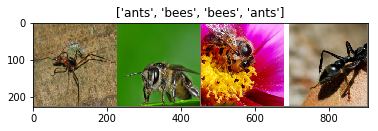

In [3]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6691 Acc: 0.6885
val Loss: 0.3078 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5507 Acc: 0.7664
val Loss: 0.2424 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.6414 Acc: 0.7623
val Loss: 0.2867 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4302 Acc: 0.8197
val Loss: 0.2043 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5619 Acc: 0.7992
val Loss: 0.3396 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.5197 Acc: 0.7828
val Loss: 0.2405 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.6086 Acc: 0.7582
val Loss: 0.3242 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3834 Acc: 0.8402
val Loss: 0.2426 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.2446 Acc: 0.9016
val Loss: 0.2371 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3056 Acc: 0.8689
val Loss: 0.2367 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3288 Acc: 0.8566
val Loss: 0.2274 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2944 Acc: 0.8770
val Loss: 0.2291 Acc: 0.9150

Ep

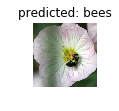

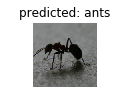

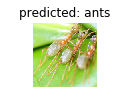

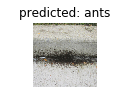

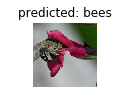

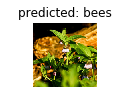

In [13]:
visualize_model(model_ft)

In [15]:
print(model_ft.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [26]:
model_tl = models.resnet18(pretrained=True)
for param in model_tl.parameters():
    param.require_grad = False
    
num_ftrs = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_ftrs, 2)

model_tl = model_tl.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_tl = optim.SGD(model_tl.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_tl, step_size=7, gamma=0.1)


In [ ]:
model_tl = train_model(model_tl, criterion, optimizer_tl, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6343 Acc: 0.6516
val Loss: 0.2209 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.7486 Acc: 0.6639
val Loss: 0.1980 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3671 Acc: 0.8443
val Loss: 0.2332 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4610 Acc: 0.7992
val Loss: 0.2017 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4516 Acc: 0.7746
val Loss: 0.2157 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.6449 Acc: 0.7705
val Loss: 0.1597 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5711 Acc: 0.7336
val Loss: 0.1872 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3287 Acc: 0.8484
val Loss: 0.1884 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3722 Acc: 0.8197
val Loss: 0.1886 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3598 Acc: 0.8320
val Loss: 0.1752 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4310 Acc: 0.8033
val Loss: 0.1727 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3652 Acc: 0.8443
val Loss: 0.1856 Acc: 0.9216

Ep